<a href="https://colab.research.google.com/github/bishair/Model-Improvements/blob/main/G10WithRetraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import joblib
from IPython.display import display, clear_output

In [3]:
uploaded_file = files.upload()

Saving riverL.xlsx to riverL.xlsx


In [4]:
# Read the groundwater level data
gw_data = pd.read_excel('groundwater.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
#print(gw_data)

# Read the river water level data
river_data = pd.read_excel('riverL.xlsx')
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%d/%m/%Y %H:%M')
#print(river_data)

# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)
print(merged_data)

                         G10  River
Date                               
2015-01-30 12:18:00  110.722    261
2015-01-30 13:18:00  110.720    260
2015-01-30 14:18:00  110.718    260
2015-01-30 15:18:00  110.715    260
2015-01-30 16:18:00  110.714    260
...                      ...    ...
2017-01-30 10:19:00  109.456    136
2017-01-30 11:19:00  109.455    138
2017-01-30 12:19:00  109.456    141
2017-01-30 13:19:00  109.457    144
2017-01-30 14:19:00  109.459    146

[17329 rows x 2 columns]


In [5]:
n_steps = 24

# Create a copy of the DataFrame to have date as column
merged_data_copy = merged_data.copy()
merged_data_copy.reset_index(inplace=True)
dates = merged_data_copy['Date']


# Split the merged data 70% training 30% testing
train_size = int(len(merged_data) * 0.7)
merged_data_train = merged_data[:train_size]
merged_data_test = merged_data[train_size:]


# Split dates along with the data
dates_train = dates[:train_size]
dates_test = dates[train_size:]

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(merged_data_train)
test_scaled = scaler.transform(merged_data_test)

#Save the scaler
joblib.dump(scaler, 'scaler.gz')

def create_sequences_with_dates(data, dates, n_steps):
    X, y, dates_seq = [], [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])
        dates_seq.append(dates.iloc[i - n_steps + 1 : i + 1])  # Capture the full range of dates for each sequence
    return np.array(X), np.array(y), np.array(dates_seq)

# create sequences
X_train, y_train, dates_train_seq = create_sequences_with_dates(train_scaled, dates_train, n_steps)
X_test, y_test, dates_test_seq = create_sequences_with_dates(test_scaled, dates_test, n_steps)

#Numpy arrays
#print('X_train shape:', X_train.shape)
#print('y_train shape:', y_train.shape)
#print('X_test shape:', X_test.shape)
#print('y_test shape:', y_test.shape)
#print('Dates for training data',dates_train_seq)
#print('Dates for testing data',dates_test_seq.shape)

In [6]:
from sklearn.model_selection import train_test_split

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Epoch 1/25
606/606 [==============================] - ETA: 0s - loss: 0.0543
Epoch 1: val_loss improved from inf to 0.00496, saving model to best_model.h5
606/606 [==============================] - 57s 80ms/step - loss: 0.0543 - val_loss: 0.0050
Epoch 2/25
  2/606 [..............................] - ETA: 31s - loss: 0.0094

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


605/606 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 2: val_loss improved from 0.00496 to 0.00346, saving model to best_model.h5
606/606 [==============================] - 41s 68ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 3/25
606/606 [==============================] - ETA: 0s - loss: 0.0051
Epoch 3: val_loss improved from 0.00346 to 0.00207, saving model to best_model.h5
606/606 [==============================] - 44s 73ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 4/25
606/606 [==============================] - ETA: 0s - loss: 0.0045
Epoch 4: val_loss improved from 0.00207 to 0.00190, saving model to best_model.h5
606/606 [==============================] - 38s 63ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 5/25
606/606 [==============================] - ETA: 0s - loss: 0.0042
Epoch 5: val_loss did not improve from 0.00190
606/606 [==============================] - 38s 63ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 6/25
606/606 [==========================

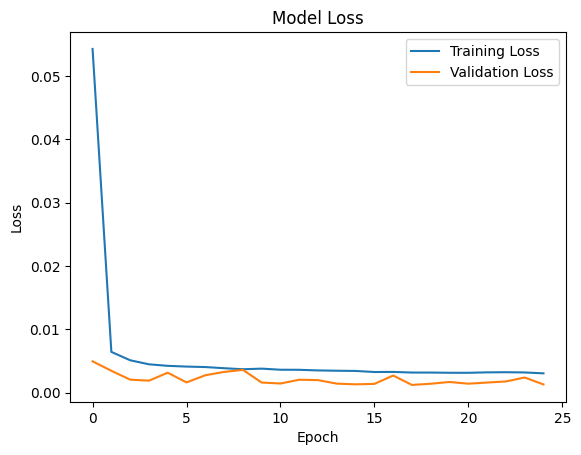

In [7]:
input_shape=(X_train.shape[1], X_train.shape[2])

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape,   #input shape => (timesteps, features).  X => (samples, timesteps, features)
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Fit the model with validation data and callbacks
history = model.fit(
    X_train, y_train, epochs=25, batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
model.save('lstmmodel.h5')
model = load_model('lstmmodel.h5')
scaler = joblib.load('scaler.gz')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (5175, 24, 2)
y_test shape: (5175,)


In [12]:
uploaded_file = files.upload()

Saving RiverAnomalous.xlsx to RiverAnomalous.xlsx


In [13]:
# Read the groundwater level data
gw_data = pd.read_excel('GWAnomalous.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
#print(gw_data)

# Read the river water level data
river_data = pd.read_excel('RiverAnomalous.xlsx')
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%d/%m/%Y %H:%M')
#print(river_data)

# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)
print(merged_data)


                         G10  River
Date                               
2016-06-20 14:13:00  109.782    176
2016-06-20 15:13:00  109.783    176
2016-06-20 16:13:00  109.783    175
2016-06-20 17:13:00  109.786    175
2016-06-20 18:13:00  109.785    174
...                      ...    ...
2017-01-30 10:19:00  109.456    136
2017-01-30 11:19:00  109.455    138
2017-01-30 12:19:00  109.456    141
2017-01-30 13:19:00  109.457    144
2017-01-30 14:19:00  109.459    146

[5176 rows x 2 columns]


In [15]:
n_steps = 24

# Create a copy of the DataFrame to have date as column
merged_data_copy = merged_data.copy()
merged_data_copy.reset_index(inplace=True)
dates = merged_data_copy['Date']


test_scaled = scaler.transform(merged_data)


def create_sequences_with_dates(data, dates, n_steps):
    X, y, dates_seq = [], [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])
        dates_seq.append(dates.iloc[i - n_steps + 1 : i + 1])  # Capture the full range of dates for each sequence
    return np.array(X), np.array(y), np.array(dates_seq)

# create sequences
X_test, y_test, dates_test_seq = create_sequences_with_dates(test_scaled, dates_test, n_steps)
print(X_test.shape)
print(y_test.shape)
print(dates_test_seq )

(5152, 24, 2)
(5152,)
[['2016-06-19T16:13:00.000000000' '2016-06-19T17:13:00.000000000'
  '2016-06-19T18:13:00.000000000' ... '2016-06-20T13:13:00.000000000'
  '2016-06-20T14:13:00.000000000' '2016-06-20T15:13:00.000000000']
 ['2016-06-19T17:13:00.000000000' '2016-06-19T18:13:00.000000000'
  '2016-06-19T19:13:00.000000000' ... '2016-06-20T14:13:00.000000000'
  '2016-06-20T15:13:00.000000000' '2016-06-20T16:13:00.000000000']
 ['2016-06-19T18:13:00.000000000' '2016-06-19T19:13:00.000000000'
  '2016-06-19T20:13:00.000000000' ... '2016-06-20T15:13:00.000000000'
  '2016-06-20T16:13:00.000000000' '2016-06-20T17:13:00.000000000']
 ...
 ['2017-01-28T14:19:00.000000000' '2017-01-28T15:19:00.000000000'
  '2017-01-28T16:19:00.000000000' ... '2017-01-29T11:19:00.000000000'
  '2017-01-29T12:19:00.000000000' '2017-01-29T13:19:00.000000000']
 ['2017-01-28T15:19:00.000000000' '2017-01-28T16:19:00.000000000'
  '2017-01-28T17:19:00.000000000' ... '2017-01-29T12:19:00.000000000'
  '2017-01-29T13:19:00.00

In [16]:

# Function to retrain the model with new data
def retrain_model(model, X_new, y_new, epochs=5, batch_size=32):
    # Partial retraining of the model with new data
    model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, shuffle=True)
    return model


In [19]:
window_size = 24
retrain_flag = True  # Set to False to compare without retraining

# Initializing lists to store results
actual_values = []
predicted_values = []
errors = []
anomaly_errors = []  # Track MSE for anomalies
dates_for_plotting = []
anomalies = []

#for i in range(min(360, X_test.shape[0])):
for i in range(X_test.shape[0]):
    X_input = X_test[i, :, :]
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

    forecast = model.predict(X_input)
    dummy = np.zeros((1, 2))
    dummy[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy)[0, 0]
    predicted_values.append(forecasted_value)

    actual = y_test[i] if i < len(y_test) else None
    if actual is not None:
        actual_transformed = scaler.inverse_transform([[actual, 0]])[0, 0]
        actual_values.append(actual_transformed)

    error = abs(forecasted_value - actual_transformed)
    errors.append(error)

    last_date = pd.to_datetime(dates_test_seq[i][-1])
    dates_for_plotting.append(last_date)

    if len(errors) >= window_size:
        windowed_errors = errors[-window_size:]
        mean_error = np.mean(windowed_errors)
        std_error = np.std(windowed_errors)
        threshold = mean_error + 2.5 * std_error

        windowed_anomalies = [j for j, e in enumerate(windowed_errors) if e > threshold]
        if windowed_anomalies:
            anomaly_indices = [i - window_size + 1 + j for j in windowed_anomalies]
            anomalies.extend(anomaly_indices)
            for idx in anomaly_indices:
                anomaly_errors.append((predicted_values[idx] - actual_values[idx]) ** 2)

            if retrain_flag:
                # Retrain the model with the most recent window of data
                model = retrain_model(model, X_test[i-window_size+1:i+1, :], y_test[i-window_size+1:i+1])

# Calculate and print MSE for anomalies
anomaly_mse = np.mean(anomaly_errors) if anomaly_errors else 0
print("MSE for Anomalies:", anomaly_mse)
print(actual_values)
print(predicted_values)
print(errors)

Streaming output truncated to the last 5000 lines.
Epoch 5/5
1/1 [==============================] - 0s 37ms/step
Epoch 1/5
1/1 [==============================] - 0s 72ms/step - loss: 0.0191
Epoch 2/5
1/1 [==============================] - 0s 104ms/step - loss: 0.0150
Epoch 3/5
1/1 [==============================] - 0s 110ms/step - loss: 0.0117
Epoch 4/5
1/1 [==============================] - 0s 109ms/step - loss: 0.0105
Epoch 5/5
1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - 0s 73ms/step - loss: 0.0023
Epoch 2/5
1/1 [==============================] - 0s 116ms/step - loss: 0.0029
Epoch 3/5
1/1 [==============================] - 0s 112ms/step - loss: 0.0030
Epoch 4/5
1/1 [==============================] - 0s 109ms/step - loss: 0.0041
Epoch 5/5
1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - 0s 69ms/step - loss: 0.0047
Epoch 2/5
1/1 [==============================] - 0s 121ms/step -

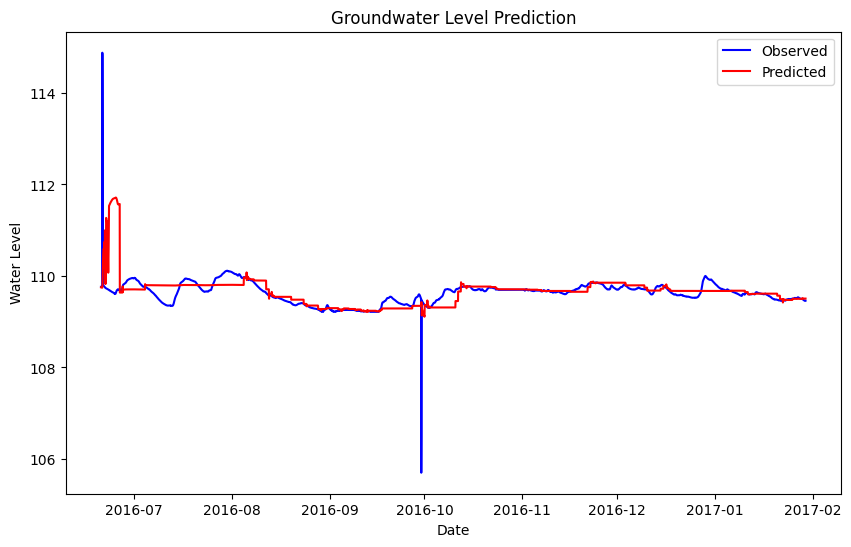

In [20]:

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dates_for_plotting, actual_values, label='Observed', color='blue')
ax.plot(dates_for_plotting, predicted_values, label='Predicted', color='red')

ax.set_title('Groundwater Level Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Water Level')
ax.legend()

plt.show()
